# Spitfire Example: flamelet generation for a methane shear layer

In [20]:
from spitfire.chemistry.mechanism import ChemicalMechanismSpec
from spitfire.chemistry.tabulation import build_adiabatic_eq_library, \
    build_adiabatic_bs_library, \
    build_adiabatic_slfm_library
import matplotlib.pyplot as plt
import numpy as np

First we set up a few streams that will be mixed and set specially for running a flow-resolved shear layer DNS

In [43]:
m = ChemicalMechanismSpec(cantera_xml='methane-lu30.xml', group_name='methane-lu30')

pressure = 101325.

ch4 = m.stream('TPY', (298., pressure, 'CH4:1'))
n2 = m.stream('TPY', (298., pressure, 'N2:1'))
air = m.stream(stp_air=True)

Next we mix the methane and nitrogen streams so that the stoichiometric mixture fraction (with air as the oxidizer) is 0.5, using a built-in Spitfire method.

Then the densities of the fuel and air streams are equated with the Cantera `DP` (density and pressure) setting, allowing the temperature to change.

In [44]:
fuel = m.mix_fuels_for_stoich_mixture_fraction(ch4, n2, 0.5, air)
air.DP = fuel.density, pressure

Next we set up our flamelet specifications and build a equilibrium, Burke-Schumann, and SLFM libraries with the high-level methods in the `tabulation` module.

Note that in this example we set `verbose=True`, which shows tabulation progress, and `solver_verbose=False`, which hides internal details of the solvers, on the SLFM call. Setting `solver_verbose=True` to see internal solver details would show that this configuration, because the high stoichiometric mixture fraction leads to an extremely weak flame, is quite challenging to solve. The most aggressive solvers try and fail on this problem and it ultimately is solved (less quickly) by a transient approach to the steady state with implicit Runge-Kutta methods. Typically this is unnecessary.

In [45]:
flamelet_specs = {'mech_spec': m,
                  'pressure': pressure,
                  'oxy_stream': air,
                  'fuel_stream': fuel,
                  'grid_points': 128,
                  'include_enthalpy_flux': True,
                  'include_variable_cp': True}

quantities = ['enthalpy', 'temperature', 'mass fraction OH']

l_eq = build_adiabatic_eq_library(flamelet_specs, quantities, verbose=False)
l_bs = build_adiabatic_bs_library(flamelet_specs, quantities, verbose=False)
l_sl = build_adiabatic_slfm_library(flamelet_specs, quantities,
                                    diss_rate_values=np.logspace(-4, np.log10(2), 36),
                                    diss_rate_ref='stoichiometric',
                                    verbose=True,
                                    solver_verbose=False)

----------------------------------------------------------------------------------
building adiabatic SLFM library
----------------------------------------------------------------------------------
- mechanism: methane-lu30.xml
- 30 species, 184 reactions
- stoichiometric mixture fraction: 0.500
----------------------------------------------------------------------------------
   1/  36 (chi_stoich =  1.0e-04 1/s)  converged in  16.14 s, T_max = 1505.3
   2/  36 (chi_stoich =  1.3e-04 1/s)  converged in   0.03 s, T_max = 1504.8
   3/  36 (chi_stoich =  1.8e-04 1/s)  converged in   0.04 s, T_max = 1504.5
   4/  36 (chi_stoich =  2.3e-04 1/s)  converged in   0.92 s, T_max = 1504.1
   5/  36 (chi_stoich =  3.1e-04 1/s)  converged in   0.03 s, T_max = 1503.7
   6/  36 (chi_stoich =  4.1e-04 1/s)  converged in  16.68 s, T_max = 1503.3
   7/  36 (chi_stoich =  5.5e-04 1/s)  converged in   0.03 s, T_max = 1502.8
   8/  36 (chi_stoich =  7.2e-04 1/s)  converged in   0.03 s, T_max = 1502.2
   9

<IPython.core.display.Javascript object>


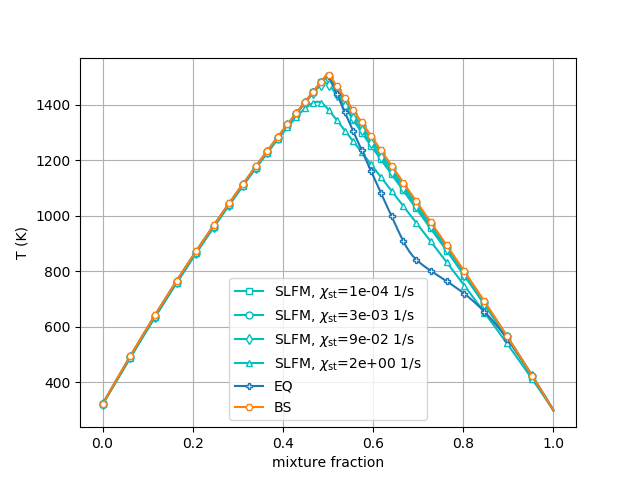

<IPython.core.display.Javascript object>


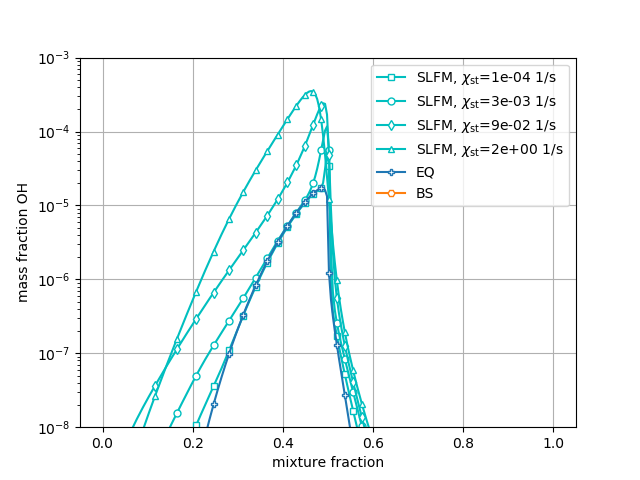

In [53]:
%matplotlib notebook

chi_indices_plot = [0, 12, 24, 35]
chi_values = l_sl.dim('dissipation_rate_stoich').values
z = l_sl.dim('mixture_fraction').values

for ix, marker in zip(chi_indices_plot, ['s', 'o', 'd', '^']):
    plt.plot(z, l_sl['temperature'][:, ix], 'c-',
             marker=marker, markevery=4, markersize=5, markerfacecolor='w',
             label='SLFM, $\\chi_{\\mathrm{st}}$=' + '{:.0e} 1/s'.format(chi_values[ix]))

plt.plot(z, l_eq['temperature'], 'P-', markevery=4, markersize=5, markerfacecolor='w', label='EQ')
plt.plot(z, l_bs['temperature'], 'H-', markevery=4, markersize=5, markerfacecolor='w', label='BS')

plt.xlabel('mixture fraction')
plt.ylabel('T (K)')
plt.grid(True)
plt.legend(loc='best')
plt.show()

plt.figure()
for ix, marker in zip(chi_indices_plot, ['s', 'o', 'd', '^']):
    plt.plot(z, l_sl['mass fraction OH'][:, ix], 'c-',
             marker=marker, markevery=4, markersize=5, markerfacecolor='w',
             label='SLFM, $\\chi_{\\mathrm{st}}$=' + '{:.0e} 1/s'.format(chi_values[ix]))

plt.plot(z, l_eq['mass fraction OH'], 'P-', markevery=4, markersize=5, markerfacecolor='w', label='EQ')
plt.plot(z, l_bs['mass fraction OH'], 'H-', markevery=4, markersize=5, markerfacecolor='w', label='BS')

plt.yscale('log')
plt.ylim([1e-8, 1e-3])
plt.xlabel('mixture fraction')
plt.ylabel('mass fraction OH')
plt.grid(True)
plt.legend(loc='best')
plt.show()
